In [1]:
from neuron import h, units, rxd, load_mechanisms
from neuron.units import mV, ms, um, mM
import math
from matplotlib import pyplot as plt
h.load_file("stdrun.hoc")
%matplotlib inline
from itertools import product
import plotly.express as px
import pandas as pd

--No graphics will be displayed.


In [8]:
# ! nrnivmodl
load_mechanisms("/blue/lamb/robert727/temp/Model-of-Pancreatic-Islets/Test")

True

The goal of this next simulation is to see how concentration is read when the location being read is a point that defines cell location. I will test this in a 30x30x30 ecs with a step size of 10. You can picture the ecs as being a rubix cube. I will make the cell have a length and diameter of 10 and it will be fully contained in the center voxel. I will leave the diffusivity constant as 0 to check and see the effect. The concentration of the central voxel should be the concentration directly outside of the cell.

In [9]:
# Create cell and insert one mechanism
my_cell = h.Section(name = "my_cell")
my_cell.insert("steady_k")

my_cell

In [3]:
# Give cell length and diameter of 10 micrometers
my_cell.pt3dadd(10,15,15,10)
my_cell.pt3dadd(20,15,15,10)

In [4]:
ecs = rxd.Extracellular(0,0,0,30,30,30, dx = (10, 10, 10))

In [5]:
# Leave d = 0 so no diffusion meaning insulin should stay right outside of membrane
k = rxd.Species(ecs, name = "k", d = 0, charge = 1, initial = 3)

In [6]:
k.initial

3

In [7]:
k[ecs].states3d

array([[[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]],

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]],

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]]])

In [8]:
my_cell(0.5).area()

314.1592653589793

In [9]:
# Create cartesian product of all possible index combinations to create recording vectors for each voxel.
coords = list(product([0,1,2], repeat = 3))
coords = [list(coord) for coord in coords]

In [10]:
# Create doctionary of recording vectors for each voxel
vect_dict = {}
for i in range(len(coords)):
    vect_dict["k" + str(coords[i])] = h.Vector()
    vect_dict["k" + str(coords[i])].record(k[ecs].node_by_ijk(coords[i][0], coords[i][1], coords[i][2])._ref_value)    

In [11]:
# record the time
t_vec = h.Vector()
t_vec.record(h._ref_t)

# run the simulation
h.finitialize()
h.continuerun(2000 * ms)

0.0

In [ ]:
# Save each plot as it's own image
for i in range(len(coords)):
    plt.plot(t_vec, vect_dict["k" + str(coords[i])])
    plt.title("k" + str(coords[i]))
    plt.savefig("Plots/Every_node_d_1/k" + str(coords[i]) + ".png")
    plt.close()

We can see from the figures and from `states3d` that k did not diffuse further into the ecs. The math below shows that the concentration of k in the central voxel is what is expected from the current stated in the mod file.

In [12]:
k[ecs].states3d

array([[[ 3.        ,  3.        ,  3.        ],
        [ 3.        ,  3.        ,  3.        ],
        [ 3.        ,  3.        ,  3.        ]],

       [[ 3.        ,  3.        ,  3.        ],
        [ 3.        , 68.12062682,  3.        ],
        [ 3.        ,  3.        ,  3.        ]],

       [[ 3.        ,  3.        ,  3.        ],
        [ 3.        ,  3.        ,  3.        ],
        [ 3.        ,  3.        ,  3.        ]]])

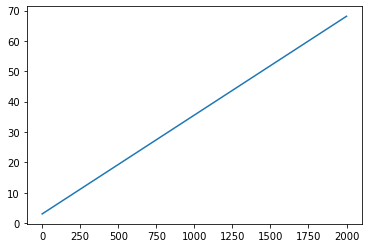

In [13]:
plt.plot(t_vec, vect_dict['k[1, 1, 1]'])

## Reading concentration in cell

It appears at the 0 end and halfway through the Section that the concentration being read is the concentration inside the Section. Concentration is measured in mM in NEURON, so here the concentration increases from 3 to 68.12 mM in 2000 ms. This means that the concentration increased 65.12 mM in 2000 ms. 65.12 mM is 0.06512 M = 0.06512 mols/L. Since we are measuring this concentration in a 10x10x10 voxel, the voxel has a volume of $1000 um^3$. There are $10^{15} um^3$ in a liter making the volume of our voxel $10^{-12}$ L. This means that during the 2000 ms simulation, 0.06512 mols/L * $10^{-12}$ L = 6.512 * $10^{-14}$ mols of $K^+$ accumulated in our voxel. This would mean $6.512 * 10^{-14} * 6.022 * 10^{23} = 3.9215264 * 10^{10} K^+ particles$ accumulated in the voxel during the simulation. Given that potassium has a charge of $1.602 * 10^{-19} C$, this would mean that $3.9215264 * 10^{10} * 1.602 * 10^{-19} = 6.282 * 10^{-9}$ coulombs accumulated in the voxel during the simulation. This would imply a current of $6.282 * 10^{-9} C / 2 s = 3.141 * 10^{-9} A = 3.141 * 10^{-6} mA$. Since steady_k is a density mechanism, the current is given in $mA/cm^2$ because it is distributed over the surface of the section. Our section has an area of $314.1 um^2$ which is $314.1 * 10^{-8} cm^{2} = 3.141 * 10^{-6} cm^{2}$. This would give us a current density of 1 $mA/cm^2$ as stated in the mod file. So it seems that when we read the concentration from a voxel that is located inside the cell, we read the concentration inside of the cell which is very convenient.

I am going to write a function that does all of this so I can quickly check what effect the diffusuivity constant has when I increase it by quantities of 0.5.

In [ ]:
class ecs_simulation_d_test:
    def __init__(self, cell_name, mech, coord_1, coord_2, diam):
        self.cell = h.Section(name = cell_name)
        self.cell.insert(mech)
        self.cell.pt3dadd(coord_1[0], coord_1[1], coord_1[2], diam)
        self.cell.pt3dadd(coord_2[0], coord_2[1], coord_2[2], diam)

